# Thematic differences GB

DHH23 Parliament group

Author: Pontus H.

Conservatives + Liberal Democrats: 11.05.2010 – 08.05.2015 (Cameron–Clegg coalition)

Conservatives: 08.05.2015 – 13.07.2016 (Second Cameron ministry)

Conservatives: 13.07.2016 – 11.07.2017 (First May Ministry)

Conservatives: 11.07.2017 – 24.07.2019 (Second May Ministry)

Conservatives: 24.07.2019 – 16.12.2019 (First Johnson Ministry)

Conservatives: 16.12.2019 – 06.09.2022 (Second Johnson Ministry)

In [246]:
# Set the theme here
THEME = 'gender_GB'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [247]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

Set up the BERTopic pipeline

In [248]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 50
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [249]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-GB_2017-11-20-commons.u520,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Morgan, Nicky",F,-,I am grateful to be granted this Adjournment d...,I was therefore pleased to publish the Govern...,0.711426,2168
1,ParlaMint-GB_2017-11-20-commons.u522,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Morgan, Nicky",F,-,I thank my hon. Friend very much for that. I a...,Friend very much for that. I am going on to s...,0.693848,446
2,ParlaMint-GB_2017-11-20-commons.u524,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Morgan, Nicky",F,-,I agree very much with what the hon. Gentleman...,"Gentleman says, and I know that he is a great...",0.515137,9435
3,ParlaMint-GB_2017-11-20-commons.u525,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"James, Margot Cathleen",F,-,I thank my right hon. Friend the Member for Lo...,Friend the Member for Loughborough (Nicky Mor...,0.797363,5917
4,ParlaMint-GB_2017-11-20-commons.u527,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"James, Margot Cathleen",F,-,I will certainly consider what my right hon. F...,Friend said; she certainly makes a powerful c...,0.735840,797


In [250]:
# Reference running time for this cell: 37s
topics, probs = topic_model.fit_transform(df['speech'])


In [251]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
# Reduce outliers
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.05)

Number of topics before: 17


In [252]:
pd.Series(new_topics).value_counts()

 0     776
 1     537
 2     419
 4     321
 3     308
 6     262
 5     248
 7     239
 9     112
 8     102
 12     84
 10     77
 11     72
 15     62
 13     59
 14     57
-1       5
dtype: int64

In [253]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [254]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [255]:
print(f"Number of topics after: {len(pd.Series(new_topics).unique())}")

Number of topics after: 17


In [256]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     793
 15    627
 12    399
 5     310
 9     261
 6     219
 8     207
 14    202
 4     190
 1      88
 10     86
 2      68
 0      66
 13     59
 11     58
 7      55
 3      52
dtype: int64

In [257]:
topic_model.visualize_topics()

Topics over time

In [258]:
# Reference running time for this cell: 2min 30s
#topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [259]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [260]:
#topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [261]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

Save relevant speeches from a particular subtopic

In [262]:
# Get the most relevant speeches from a topic and save to a text file

def save_topic_speeches(topic_id):
    speeches = topic_model.get_representative_docs(topic_id)
    with open(f"{OUTPUT_PATH}{THEME}_topic{topic_id}_speeches.txt", "w", encoding="utf-8") as file:
        file.write(f"Relevant speeches for theme {THEME} and topic {topic_id}\n\n")
        for speech in speeches:
            file.write(speech)
            file.write("\n\n")
for topic_id in range(10):
    save_topic_speeches(topic_id)

# Word Clouds

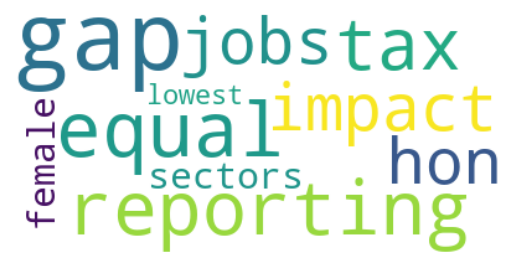

In [263]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [264]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [265]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['gap',
 'equal',
 'reporting',
 'tax',
 'impact',
 'jobs',
 'hon',
 'sectors',
 'female',
 'lowest']

In [266]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Set the party name to 'OTHER' if the party name does not contain 'CON', 'LAB' or 'SNP'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('CON|LAB|SNP'), 'party'] = 'OTHER'
# Set the party name to CON if the party name contains 'CON'
speech_topic_party.loc[speech_topic_party['party'].str.contains('CON'), 'party'] = 'CON'
# Set the party name to SNP if the party name contains 'SNP'
speech_topic_party.loc[speech_topic_party['party'].str.contains('SNP'), 'party'] = 'SNP'
# Set the party name to LAB if the party name contains 'LAB'
speech_topic_party.loc[speech_topic_party['party'].str.contains('LAB'), 'party'] = 'LAB'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,CON,LAB,OTHER,SNP
topic,,,,
0,462,218,29,67
1,263,173,17,84
2,237,115,12,55
3,147,118,11,32
4,162,92,21,46
5,108,104,13,23
6,129,86,10,37
7,89,84,13,53
8,48,37,5,12


In [267]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,CON,LAB,OTHER,SNP
topic,,,,
0,27.5,20.2,21.6,15.4
1,15.7,16.0,12.7,19.4
2,14.1,10.7,9.0,12.7
3,8.8,10.9,8.2,7.4
4,9.7,8.5,15.7,10.6
5,6.4,9.6,9.7,5.3
6,7.7,8.0,7.5,8.5
7,5.3,7.8,9.7,12.2
8,2.9,3.4,3.7,2.8


In [268]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,CON,LAB,OTHER,SNP,keywords
topic,,,,,
0,27.5,20.2,21.6,15.4,"[gap, equal, reporting, tax, impact, jobs, hon..."
1,15.7,16.0,12.7,19.4,"[lgbt, rights, human, commonwealth, foreign, c..."
2,14.1,10.7,9.0,12.7,"[transgender, hiv, prisoners, 2004, nhs, equal..."
3,8.8,10.9,8.2,7.4,"[member, armed, jo, constituency, building, sp..."
4,9.7,8.5,15.7,10.6,"[domestic, victims, convention, sexual, istanb..."
5,6.4,9.6,9.7,5.3,"[online, bullying, relationships, young, curri..."
6,7.7,8.0,7.5,8.5,"[gender, hon, celebrate, parliament, friend, p..."
7,5.3,7.8,9.7,12.2,"[scotland, insert, page, regulations, leave, s..."
8,2.9,3.4,3.7,2.8,"[hate, metropolitan, crime, proscription, isil..."


In [269]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,CON,LAB,OTHER,SNP
0,0,59.5,28.1,3.7,8.6
1,1,49.0,32.2,3.2,15.6
2,2,56.6,27.4,2.9,13.1
3,3,47.7,38.3,3.6,10.4
4,4,50.5,28.7,6.5,14.3
5,5,43.5,41.9,5.2,9.3
6,6,49.2,32.8,3.8,14.1
7,7,37.2,35.1,5.4,22.2
8,8,47.1,36.3,4.9,11.8
9,9,29.5,45.5,2.7,22.3


Calculate mean sentiment for each topic per party

In [270]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment'], 'speech': df['speech'], 'speech_date': df['Date'], 'probs': list(probs)})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Set the party name to 'OTHER' if the party name does not contain 'CON', 'LAB' or 'SNP'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('CON|LAB|SNP'), 'party'] = 'OTHER'
# Set the party name to CON if the party name contains 'CON'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('CON'), 'party'] = 'CON'
# Set the party name to SNP if the party name contains 'SNP'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('SNP'), 'party'] = 'SNP'
# Set the party name to LAB if the party name contains 'LAB'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('LAB'), 'party'] = 'LAB'
# Create a new dataframe with the relevant speeches
relevant_speeches = sentiment_topic_party[['topic', 'party', 'sentiment', 'speech', 'speech_date','probs']].copy()
sentiment_topic_party.drop(columns=['speech', 'speech_date', 'probs'], inplace=True)
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,CON,LAB,OTHER,SNP
topic,,,,
0,0.27,-0.28,-0.15,-0.34
1,0.22,-0.12,-0.31,-0.17
2,0.18,-0.18,-0.48,-0.09
3,0.37,0.29,0.44,0.40
4,0.03,-0.28,-0.25,0.01
5,0.09,-0.31,-0.27,-0.23
6,0.37,0.18,0.35,0.08
7,0.31,-0.15,-0.35,-0.05
8,-0.24,-0.35,-0.45,-0.20


In [271]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")

In [279]:
import numpy as np

def get_top_10(topic_id, party_name):
    speeches_for_topic_0_con = relevant_speeches[(relevant_speeches['party'] == party_name) & (relevant_speeches['topic'] == topic_id)]
    speeches_for_topic_0_con['probs'] = speeches_for_topic_0_con['probs'].apply(lambda x: x[topic_id])
    speeches_for_topic_0_con = speeches_for_topic_0_con.sort_values(by='probs', ascending=False)
    return speeches_for_topic_0_con.head(10)

parties = ['CON', 'LAB', 'SNP', 'OTHER']

get_top_10(0, 'LAB')

,topic,party,sentiment,speech,speech_date,probs
1296,0,LAB,0.316406,I congratulate the hon. Member for Inverclyde ...,2015-07-01,1.000000
2839,0,LAB,-0.216431,"It is estimated that 1,557 companies employing...",2018-04-18,0.993502
2724,0,LAB,-0.820801,"I appreciate the hon. Lady’s comments, but is ...",2018-11-20,0.992772
1276,0,LAB,-0.216431,Since the Government introduced fees for tribu...,2015-07-01,0.992520
2953,0,LAB,-0.005375,I was disappointed to hear recently from the h...,2018-01-25,0.992321
3403,0,LAB,-0.416748,"On a point of order, Mr Speaker. I have just c...",2019-04-04,0.992019
3170,0,LAB,-0.216431,The new Minister for Women and Equalities made...,2018-05-17,0.991682
2130,0,LAB,-0.499756,The private sector has made great progress in ...,2016-04-14,0.991602
1303,0,LAB,0.111206,"Before I speak to the motion, I would like to ...",2015-07-01,0.991351
2288,0,LAB,0.046906,"I will not, if my hon. Friend will forgive me,...",2016-03-08,0.991332
